In [8]:
import scanpy as sc 
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors, cm
import numpy as np
import scipy
import os

from utils import plot_histogram
from var import *

import pertpy as pt

In [9]:
#set seed to 0 for reproducibility of results
np.random.seed(0)

In [10]:
#Create figures folder
figures_folder = os.path.join(results_folder, 'figures/cellcycle/')
if not os.path.exists(figures_folder):
    os.makedirs(figures_folder)

<h3> 1. Data exploration of filtered data </h3>

In [11]:
#load log normlised adata object with filter for cells with more than 5000 UMI counts expressed
adata_preprocessed = sc.read_h5ad(f'/lustre/scratch123/hgi/teams/parts/kl11/cell2state_tf_activation/results/20230116_adata_pre_processed.h5ad')

In [12]:
#load adata obs object from crispra csv file
adata_obs_df=pd.read_csv('/lustre/scratch123/hgi/teams/parts/kl11/cell2state_tf_activation/data/crispra_data_exploration/20230202_perturbation_state.csv', index_col=0)
#order index of adata_obs_df to match adata_preprocessed
adata_obs_df = adata_obs_df.reindex(adata_preprocessed.obs.index)
#check that the index of adata_obs_df matches adata_preprocessed
assert adata_obs_df.index.equals(adata_preprocessed.obs.index)
#overwrite adata_preprocessed.obs with adata_obs_df
adata_preprocessed.obs = adata_obs_df

#filter out cells that are not in the perturbation state
adata_pertubed = adata_preprocessed[adata_preprocessed.obs['perturbation_state'] != 'not_perturbed']

#### 1.1 Cell cycle score

In [13]:
cell_cycle_genes = [x.strip() for x in open('/lustre/scratch123/hgi/teams/parts/kl11/cell2state_tf_activation/data/regev_lab_cell_cycle_genes.txt')]

In [14]:
s_genes = cell_cycle_genes[:43]
s_genes = [x for x in s_genes if adata_preprocessed.var['SYMBOL'].isin([x]).any()]
g2m_genes = cell_cycle_genes[43:]
g2m_genes = [x for x in g2m_genes if adata_preprocessed.var['SYMBOL'].isin([x]).any()]

#extract ESNG cell cycle genes from adata_preprocessed
s_genes_ENSG = adata_preprocessed[:, adata_preprocessed.var['SYMBOL'].isin(s_genes)].var_names.to_list()
g2m_genes_ENSG = adata_preprocessed[:, adata_preprocessed.var['SYMBOL'].isin(g2m_genes)].var_names.to_list()


In [15]:
#filter adatapreprocessed for genes in s_genes_ENSG and g2m_genes_ENSG
adata_cell_cycle = adata_preprocessed[:, adata_preprocessed.var_names.isin(s_genes_ENSG)]

In [16]:
sc.pp.normalize_per_cell(adata_preprocessed, counts_per_cell_after=1e4)
sc.pp.scale(adata_preprocessed)

In [17]:
sc.tl.score_genes_cell_cycle(adata_preprocessed, s_genes=s_genes_ENSG, g2m_genes=g2m_genes_ENSG)

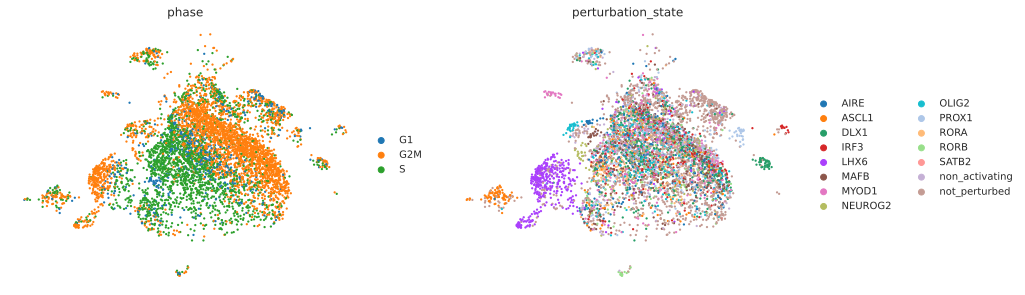

In [12]:
sc.pl.umap(adata_preprocessed, color=[ 'phase','perturbation_state'], frameon=False)

In [21]:
#regress out batch effect using scanpy
adata_preprocessed.obs["cell_cycle_diff"] = adata_preprocessed.obs["S_score"] - adata_preprocessed.obs["G2M_score"]
sc.pp.regress_out(adata_preprocessed, ['cell_cycle_diff'])
# sc.pp.regress_out(adata_preprocessed, ['S_score', 'G2M_score'])
# sc.pp.scale(adata_preprocessed)

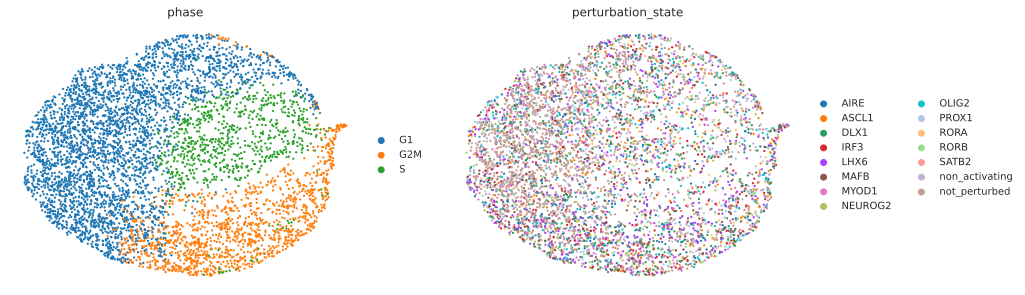

<Figure size 640x480 with 0 Axes>

In [22]:
#compute PCA and UMAP for adata_preprocessed

sc.pp.pca(adata_preprocessed,svd_solver='arpack')
sc.pp.neighbors(adata_preprocessed, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata_preprocessed)
sc.pl.umap(adata_preprocessed, color=['phase','perturbation_state'],frameon=False)
plt.savefig(os.path.join(figures_folder, f'{today}_scanpy_cell_cycle_regress.png'), dpi=300, bbox_inches='tight')

In [15]:
#assign raw counts to adata_preprocessed.X
adata_preprocessed.X = adata_preprocessed.layers['counts']
sc.pp.normalize_total(adata_preprocessed, target_sum=1e4)

#log1p correct
#remove log1p from uns 
adata_preprocessed.uns.pop('log1p')
sc.pp.log1p(adata_preprocessed)

#create new column perturbation in adata_preprocessed.obs for perturbed vs non perturbed cells based on perturbation_state
adata_preprocessed.obs['perturbation'] = adata_preprocessed.obs['perturbation_state'].apply(lambda x: 'perturbed' if x != 'non_activating' else 'non_activating')

In [16]:
#plot umap of cell cycle genes
ms = pt.tl.Mixscape()
ms.pert_sign(
    adata_preprocessed,
    pert_key="perturbation",
    control="non_activating",
    n_neighbors=20
)

In [17]:
adata_preprocessed.X = adata_preprocessed.layers['X_pert']

In [18]:
sc.pp.pca(adata_preprocessed, svd_solver='arpack')

In [19]:
sc.pp.neighbors(adata_preprocessed)

In [20]:
sc.tl.umap(adata_preprocessed)

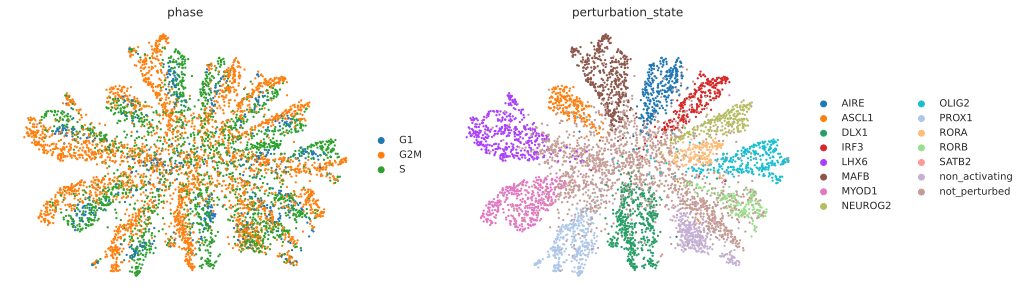

In [21]:
#plot umap of cell cycle genes
sc.pl.umap(adata_preprocessed, color=['phase','perturbation_state'], ncols=2, frameon=False, show=False)
plt.savefig(os.path.join(figures_folder, f'{today}_umap_cell_cycle_perturbation_state.pdf'), dpi=300, bbox_inches='tight')